# Document Chracterizzation


## Import of relevant libraries 

In [48]:
# Import of all the libraries used for the project
import os
import shutil
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from operator import itemgetter
import plotly.graph_objects as go
import spacy
import sklearn
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, f1_score, accuracy_score, recall_score, plot_confusion_matrix
from ray.tune.sklearn import TuneGridSearchCV, TuneSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import torch.nn.functional as F 
import torch
from scipy import stats

## Dataset import

In [2]:
# Defined a simple scraper  to go through all the link, visit the page and copy all the txt in the paragraph tag of the HTML file

def scraper(input):
    # create an empty array
    content = []

    # for loop on all the links in the dataframe
    for i in range(len(input["URL"])):
        url = input["URL"][i]
        # text = url
        text = ' '

        # check if actually the url is correct orr not
        if not (url.startswith('https://') or url.startswith('http://')):
            text += ' Link not good'
            content.append(text) 
            continue
        
        # Request the url and copy of the HTMl 
        page = requests.get(url)
        
        # Check if the response is positive or not, if not set that page was not found 
        if page.status_code != 200:
            text += ' Page not able to find'

        # Else take the text from all the p tag of the HTML content  
        else:
            soup = BeautifulSoup(page.content, 'html.parser')
            for p in soup.find_all('p'):
                text = text + ' ' + p.text
        
        content.append(text) 
    return content

In [3]:
## import the CSV file with the labels

data_scraper = pd.read_csv('Document Characterisation Data.csv', sep=',')
#print(len(data_scraper["URL"]))

# Calling the scraper function
data = scraper(data_scraper)

# Adding the scraped data into the Dataframe  
data_scraper['Content'] = data
data_scraper

,URL,Class,Content
0,https://issafrica.org/iss-today/time-to-tackle...,Analytical Report,"2020-11-25 On 26 September, hundreds of Mali..."
1,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By George Barros November 16, 2020 The Kreml..."
2,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By Ezgi Yazici November 13, 2020 Key Takeawa..."
3,http://www.understandingwar.org/backgrounder/w...,Analytical Report,By Katherine Lawlor with Brandon Wallace Key...
4,http://www.understandingwar.org/backgrounder/r...,Analytical Report,By Isabel Ivanescu and Ezgi Yazici Key Takea...
...,...,...,...
232,https://www.journalism.org/2019/03/26/for-loca...,Analytical Report,"Numbers, Facts and Trends Shaping Your World..."
233,https://www.journalism.org/2017/10/02/covering...,Analytical Report,"Numbers, Facts and Trends Shaping Your World..."
234,https://ctc.usma.edu/afghanistans-future-emira...,Analytical Report,Main Menu Seth G. Jones \nShare via:\n\n\n\n...
235,https://ctc.usma.edu/back-into-the-shadows-the...,Analytical Report,Main Menu Michael Knights \nShare via:\n\n\n...


In [4]:
# Function to load the files from local drive into Pandas data frame

def readFiles (src, fileClass):
    src_files = os.listdir(src)
    fileType = []
    content = []
    for i in range(len(src_files)):
        fileType.append(fileClass)
        glove_file = open(src + src_files[i], "r", encoding="utf8")
        glove_vectors_list = [word_and_vector.strip() for word_and_vector in glove_file.readlines()]
        content.append(" ".join(glove_vectors_list))
    
    columns = ["URL", "Class", "Content"]
    df = pd.DataFrame(columns=columns)

    df["URL"] = src_files
    df["Class"] = fileType
    df["Content"] = content

    return df


In [5]:
src = "./Data/Analytical Report/"
df_Analytical_Report = readFiles(src, "Analytical Report")

print(len(df_Analytical_Report['Content'][0]))

src = "./Data/Analytical Report2/"
df_Analytical_Report2 = readFiles(src, "Analytical Report")

print(len(df_Analytical_Report2['Content'][0]))

src = "./Data/Incident Report/"
df_Incident_Report = readFiles(src, "Incident Report")

src = "./Data/Situation Report/"
df_Situation_Report = readFiles(src, "Situation Report")

toConcat = [data_scraper, df_Analytical_Report, df_Analytical_Report2, df_Incident_Report, df_Situation_Report]

data_input = pd.concat(toConcat, ignore_index=True)
data_input

5725
5725


,URL,Class,Content
0,https://issafrica.org/iss-today/time-to-tackle...,Analytical Report,"2020-11-25 On 26 September, hundreds of Mali..."
1,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By George Barros November 16, 2020 The Kreml..."
2,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By Ezgi Yazici November 13, 2020 Key Takeawa..."
3,http://www.understandingwar.org/backgrounder/w...,Analytical Report,By Katherine Lawlor with Brandon Wallace Key...
4,http://www.understandingwar.org/backgrounder/r...,Analytical Report,By Isabel Ivanescu and Ezgi Yazici Key Takea...
...,...,...,...
413,int-rep-o-18-e.txt,Situation Report,Deputies are investigating after an explosive ...
414,int-rep-o-18-f.txt,Situation Report,Residents at a Springfield apartment complex w...
415,int-rep-o-18-g.txt,Situation Report,Several handheld explosive devices were found ...
416,int-rep-o-18-h.txt,Situation Report,Boulder police taped off the U.S. Bank at Broa...


## Experimental Data Analysis 

### Data frame informations and duplicates Duplicates

In [6]:
data_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   URL      418 non-null    object
 1   Class    418 non-null    object
 2   Content  418 non-null    object
dtypes: object(3)
memory usage: 9.9+ KB


In [7]:
# Number of items per class
print("Number of Analytical Report ", len(data_input[data_input['Class'] == 'Analytical Report']))
print("Number of Situation Report ", len(data_input[data_input['Class'] == 'Situation Report']))
print("Number of Incident Report ", len(data_input[data_input['Class'] == 'Incident Report']))
print("Number of Profile Report ", len(data_input[data_input['Class'] == 'Profile Report']))


Number of Analytical Report  131
Number of Situation Report  99
Number of Incident Report  88
Number of Profile Report  100


In [8]:
# Dropping the duplicate items 

data_input_dropped= data_input.drop_duplicates(keep="first").reset_index(drop=True)

In [9]:
# Number of items per class after dropping the duplicates
print("Number of Analytical Report ", len(data_input_dropped[data_input_dropped['Class'] == 'Analytical Report']))
print("Number of Situation Report ", len(data_input_dropped[data_input_dropped['Class'] == 'Situation Report']))
print("Number of Incident Report ", len(data_input_dropped[data_input_dropped['Class'] == 'Incident Report']))
print("Number of Profile Report ", len(data_input_dropped[data_input_dropped['Class'] == 'Profile Report']))


Number of Analytical Report  92
Number of Situation Report  98
Number of Incident Report  88
Number of Profile Report  98


In [10]:
data_input_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   URL      376 non-null    object
 1   Class    376 non-null    object
 2   Content  376 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB


### Pre Processing the data

In [11]:
# tockenizzation of the corpus 
def tokenize(corpus):

    # The backslash is an escape character to let the interpreter know we mean to use it as a string literal (- or ') 
    re_punctuation_string = '[\s,/.?\-\'`’]'  # split on spaces (\s),  commas (,), slash (/), fullstop (.), question marks (?), hyphens (-), and apostrophe (').
    tokenized = re.split(re_punctuation_string, corpus) # in python's regex, [...] is an alternative to writing .|.|.
    tokenized = list(filter(None, tokenized)) # remove empty strings from list 
    tokenized = [token.lower() for token in tokenized] # Lowercasing everything
    tokenized = ['<Number>' if token.isdigit() else token for token in tokenized ]  # converting all the numbers to <Number>


    return tokenized    



In [12]:
# function to count the tockenization
def distinct_tokens_count(tokenized_corpus):

    distinct_tokens_count = {}
    for t_review in tokenized_corpus:

        if t_review not in distinct_tokens_count.keys():
            distinct_tokens_count[t_review] = 1
        else:
            distinct_tokens_count[t_review] += 1

    # Sort the key value to greter to smaller
    distinct_tokens_count = sorted(distinct_tokens_count.items(), key=itemgetter(1), reverse=True) 

    #for token, count in distinct_tokens_count:
        #print("{:<14s} {:<10d}".format(token, count))
    return distinct_tokens_count



In [13]:
# function to pre process the text and count the number of words
def process(dataframe):

    tokenized = []
    tokens_count = []
    class_type = []
    for i in range(dataframe.shape[0]):
        #print(dataframe['Content'][i])
        #print(i)
        
        # tokenizing the corpus
        token = tokenize(dataframe['Content'][i])
        tokenized.append(token)
        # counting the tokens
        tokens_count.append(distinct_tokens_count(token))

        if dataframe['Class'][i] == 'Analytical Report':
            class_type.append(0)

        elif dataframe['Class'][i] == 'Incident Report':
            class_type.append(1)

        elif dataframe['Class'][i] == 'Profile Report':
            class_type.append(2)

        elif dataframe['Class'][i] == 'Situation Report':
            class_type.append(3)


    dataframe['Tokenized'] = tokenized
    dataframe['Tokens Count'] = tokens_count
    dataframe['Class Type'] = class_type

    return dataframe

In [14]:
data_processed = process(data_input_dropped)      

data_processed

,URL,Class,Content,Tokenized,Tokens Count,Class Type
0,https://issafrica.org/iss-today/time-to-tackle...,Analytical Report,"2020-11-25 On 26 September, hundreds of Mali...","[<Number>, <Number>, <Number>, on, <Number>, s...","[(the, 127), (and, 83), (women, 82), (to, 70),...",0
1,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By George Barros November 16, 2020 The Kreml...","[by, george, barros, november, <Number>, <Numb...","[(the, 67), (<Number>, 50), (to, 44), (csto, 3...",0
2,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By Ezgi Yazici November 13, 2020 Key Takeawa...","[by, ezgi, yazici, november, <Number>, <Number...","[(the, 41), (in, 25), (to, 24), (s, 22), (and,...",0
3,http://www.understandingwar.org/backgrounder/w...,Analytical Report,By Katherine Lawlor with Brandon Wallace Key...,"[by, katherine, lawlor, with, brandon, wallace...","[(s, 131), (the, 121), (to, 120), (<Number>, 1...",0
4,http://www.understandingwar.org/backgrounder/r...,Analytical Report,By Isabel Ivanescu and Ezgi Yazici Key Takea...,"[by, isabel, ivanescu, and, ezgi, yazici, key,...","[(in, 42), (the, 37), (and, 34), (a, 23), (to,...",0
...,...,...,...,...,...,...
371,int-rep-o-18-e.txt,Situation Report,Deputies are investigating after an explosive ...,"[deputies, are, investigating, after, an, expl...","[(the, 52), (a, 43), (was, 35), (to, 25), (dev...",3
372,int-rep-o-18-f.txt,Situation Report,Residents at a Springfield apartment complex w...,"[residents, at, a, springfield, apartment, com...","[(the, 64), (a, 47), (was, 27), (in, 22), (bom...",3
373,int-rep-o-18-g.txt,Situation Report,Several handheld explosive devices were found ...,"[several, handheld, explosive, devices, were, ...","[(the, 82), (a, 67), (bomb, 30), (to, 27), (wa...",3
374,int-rep-o-18-h.txt,Situation Report,Boulder police taped off the U.S. Bank at Broa...,"[boulder, police, taped, off, the, u, s, bank,...","[(the, 83), (a, 77), (was, 42), (to, 36), (bom...",3


### Feature extraction

In [15]:
def adding_features(dataframe):
    length = []
    unique_tokens = []
    tokens_percentage = []
    
    for i in range(dataframe.shape[0]):
        leng = len(data_processed['Tokenized'][i])
        length.append(leng)
        unique_tokens.append(len(data_processed['Tokens Count'][i]))

        distinct_tokens_percentage = {}
        for token, count in data_processed['Tokens Count'][i]:
            distinct_tokens_percentage[token] = (count * 100) / leng
        
        distinct_tokens_percentage = sorted(distinct_tokens_percentage.items(), key=itemgetter(1), reverse=True)
        tokens_percentage.append(distinct_tokens_percentage)
    
    
    dataframe['Length'] = length
    dataframe['Unique Tokens'] = unique_tokens
    dataframe['Tokens Percentage'] = tokens_percentage
    # tahen out all the page not accessible with message "Page not found"
    dataframe = dataframe[dataframe['Length'] > 10].reset_index(drop=True)

    return dataframe

In [16]:
data_add_features = adding_features(data_processed)

data_Analytical = data_add_features[data_add_features['Class'] == 'Analytical Report']
data_Incident = data_add_features[data_add_features['Class'] == 'Incident Report']
data_Profile = data_add_features[data_add_features['Class'] == 'Profile Report']
data_Situation = data_add_features[data_add_features['Class'] == 'Situation Report']

data_add_features

,URL,Class,Content,Tokenized,Tokens Count,Class Type,Length,Unique Tokens,Tokens Percentage
0,https://issafrica.org/iss-today/time-to-tackle...,Analytical Report,"2020-11-25 On 26 September, hundreds of Mali...","[<Number>, <Number>, <Number>, on, <Number>, s...","[(the, 127), (and, 83), (women, 82), (to, 70),...",0,2313,521,"[(the, 5.490704712494596), (and, 3.58841331603..."
1,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By George Barros November 16, 2020 The Kreml...","[by, george, barros, november, <Number>, <Numb...","[(the, 67), (<Number>, 50), (to, 44), (csto, 3...",0,1393,533,"[(the, 4.809763101220388), (<Number>, 3.589375..."
2,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By Ezgi Yazici November 13, 2020 Key Takeawa...","[by, ezgi, yazici, november, <Number>, <Number...","[(the, 41), (in, 25), (to, 24), (s, 22), (and,...",0,824,366,"[(the, 4.975728155339806), (in, 3.033980582524..."
3,http://www.understandingwar.org/backgrounder/w...,Analytical Report,By Katherine Lawlor with Brandon Wallace Key...,"[by, katherine, lawlor, with, brandon, wallace...","[(s, 131), (the, 121), (to, 120), (<Number>, 1...",0,3528,985,"[(s, 3.7131519274376417), (the, 3.429705215419..."
4,http://www.understandingwar.org/backgrounder/r...,Analytical Report,By Isabel Ivanescu and Ezgi Yazici Key Takea...,"[by, isabel, ivanescu, and, ezgi, yazici, key,...","[(in, 42), (the, 37), (and, 34), (a, 23), (to,...",0,878,390,"[(in, 4.783599088838269), (the, 4.214123006833..."
...,...,...,...,...,...,...,...,...,...
350,int-rep-o-18-e.txt,Situation Report,Deputies are investigating after an explosive ...,"[deputies, are, investigating, after, an, expl...","[(the, 52), (a, 43), (was, 35), (to, 25), (dev...",3,784,313,"[(the, 6.63265306122449), (a, 5.48469387755102..."
351,int-rep-o-18-f.txt,Situation Report,Residents at a Springfield apartment complex w...,"[residents, at, a, springfield, apartment, com...","[(the, 64), (a, 47), (was, 27), (in, 22), (bom...",3,791,331,"[(the, 8.09102402022756), (a, 5.94184576485461..."
352,int-rep-o-18-g.txt,Situation Report,Several handheld explosive devices were found ...,"[several, handheld, explosive, devices, were, ...","[(the, 82), (a, 67), (bomb, 30), (to, 27), (wa...",3,941,367,"[(the, 8.71413390010627), (a, 7.12008501594048..."
353,int-rep-o-18-h.txt,Situation Report,Boulder police taped off the U.S. Bank at Broa...,"[boulder, police, taped, off, the, u, s, bank,...","[(the, 83), (a, 77), (was, 42), (to, 36), (bom...",3,1355,488,"[(the, 6.125461254612546), (a, 5.6826568265682..."


In [17]:
# Function to plot the violin plot for the dataframe   
def plot_violin(df, to_be_plot):

    fig = go.Figure()

    reports = ['Analytical Report', 'Incident Report', 'Profile Report', 'Situation Report']

    for report in reports:
        fig.add_trace(go.Violin(x=df['Class'][df['Class'] == report],
                                y=df[to_be_plot][df['Class'] == report],
                                name=report,
                                box_visible=True,
                                meanline_visible=True))
    
    fig.update_layout(
    title="Violin plot of the " + to_be_plot + " for type of reports",
    yaxis_range=[0, 5000],
    )
    fig.show()

    return


In [18]:
plot_violin(data_add_features, "Length")
plot_violin(data_add_features, "Unique Tokens")

In [19]:
# function to tag the part of speech using the pre trained model from Spacy

def part_Speech_tagging(data_in):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(data_in)

    columns_tok = ["token_text", "token_lemma", "token_pos", "token_dep"]
    df_tok = pd.DataFrame(columns=columns_tok)
    text = []
    lemma = []
    pos = []
    dep =[]
    for token in doc:
        text.append(token.text)
        lemma.append(token.lemma_)
        pos.append(token.pos_)
        dep.append(token.dep_)

    df_tok["token_text"] = text
    df_tok["token_lemma"] = lemma
    df_tok["token_pos"] = pos
    df_tok["token_dep"] = dep

    return df_tok


In [20]:
# Function to add feature based on the part to speech tagging

def feature_add_speech(data):
    # counting the root of a phrase by different type might give me better some understanding of different type of the documentes
    root_verb = []
    root_noun = []
    root_propn = []
    root_aux = []
    # also the counting the type of tags used in the phrases of the document can give some insights of the type of document
    adj = []
    adv =[]
    noun = []
    num = []
    pron = []
    propn = []
    verb = []
    
    for i in range(data.shape[0]):
        #print(i)
        length = data['Length'][i]
        df_tagged = part_Speech_tagging(data['Content'][i])

        a = df_tagged[df_tagged["token_dep"] == 'ROOT']
        if 'VERB' in a['token_pos'].value_counts():
            root_verb.append(a['token_pos'].value_counts()['VERB'] * 100 / length)
        else:
            root_verb.append(0)
        
        if 'NOUN' in a['token_pos'].value_counts():
            root_noun.append(a['token_pos'].value_counts()['NOUN'] * 100 / length)
        else:
            root_noun.append(0)

        if 'AUX' in a['token_pos'].value_counts():
            root_aux.append(a['token_pos'].value_counts()['AUX'] * 100 / length)
        else:
            root_aux.append(0)

        if 'PROPN' in a['token_pos'].value_counts():
            root_propn.append(a['token_pos'].value_counts()['PROPN'] * 100 / length)
        else:
            root_propn.append(0)
        

        b = df_tagged['token_pos'].value_counts()

        if 'ADJ' in b:
            adj.append(b['ADJ'] * 100 / length)
        else:
            adj.append(0)
        
        if 'ADV' in b:
            adv.append(b['ADV'] * 100 / length)
        else:
            adv.append(0)

        if 'NOUN' in b:
            noun.append(b['NOUN'] * 100 / length)
        else:
            noun.append(0)

        if 'NUM' in b:
            num.append(b['NUM'] * 100 / length)
        else:
            num.append(0)

        if 'PRON' in b:
            pron.append(b['PRON'] * 100 / length)
        else:
            pron.append(0)

        if 'PROPN' in b:
            propn.append(b['PROPN'] * 100 / length)
        else:
            propn.append(0)

        if 'VERB' in b:
            verb.append(b['VERB'] * 100 / length)
        else:
            verb.append(0)
        

    
    data['Root_verb'] = root_verb
    data['Root_noun'] = root_noun
    data['Root_aux'] = root_aux
    data['Root_propn'] = root_propn

    data['Adj'] = adj
    data['Adv'] = adv
    data['Noun'] = noun
    data['Num'] = num
    data['Pron'] = pron
    data['Propn'] = propn
    data['Verb'] = verb

    return data



data_add_speech_tag = feature_add_speech(data_add_features)
data_add_speech_tag

,URL,Class,Content,Tokenized,Tokens Count,Class Type,Length,Unique Tokens,Tokens Percentage,Root_verb,Root_noun,Root_aux,Root_propn,Adj,Adv,Noun,Num,Pron,Propn,Verb
0,https://issafrica.org/iss-today/time-to-tackle...,Analytical Report,"2020-11-25 On 26 September, hundreds of Mali...","[<Number>, <Number>, <Number>, on, <Number>, s...","[(the, 127), (and, 83), (women, 82), (to, 70),...",0,2313,521,"[(the, 5.490704712494596), (and, 3.58841331603...",4.020752,0.172936,0.907912,0.172936,10.722006,3.112840,27.842629,2.204929,1.080847,6.009511,13.186338
1,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By George Barros November 16, 2020 The Kreml...","[by, george, barros, november, <Number>, <Numb...","[(the, 67), (<Number>, 50), (to, 44), (csto, 3...",0,1393,533,"[(the, 4.809763101220388), (<Number>, 3.589375...",2.153625,0.789663,0.143575,0.287150,7.753051,2.153625,20.459440,3.445800,0.430725,18.808327,10.050251
2,http://www.understandingwar.org/backgrounder/r...,Analytical Report,"By Ezgi Yazici November 13, 2020 Key Takeawa...","[by, ezgi, yazici, november, <Number>, <Number...","[(the, 41), (in, 25), (to, 24), (s, 22), (and,...",0,824,366,"[(the, 4.975728155339806), (in, 3.033980582524...",2.669903,0.364078,0.606796,0.364078,10.800971,3.276699,18.689320,1.699029,1.092233,16.626214,10.679612
3,http://www.understandingwar.org/backgrounder/w...,Analytical Report,By Katherine Lawlor with Brandon Wallace Key...,"[by, katherine, lawlor, with, brandon, wallace...","[(s, 131), (the, 121), (to, 120), (<Number>, 1...",0,3528,985,"[(s, 3.7131519274376417), (the, 3.429705215419...",2.097506,0.255102,0.793651,0.623583,9.325397,3.032880,15.731293,3.713152,0.963719,18.764172,8.928571
4,http://www.understandingwar.org/backgrounder/r...,Analytical Report,By Isabel Ivanescu and Ezgi Yazici Key Takea...,"[by, isabel, ivanescu, and, ezgi, yazici, key,...","[(in, 42), (the, 37), (and, 34), (a, 23), (to,...",0,878,390,"[(in, 4.783599088838269), (the, 4.214123006833...",2.847380,0.227790,0.683371,0.113895,9.794989,2.847380,17.539863,2.050114,0.113895,15.034169,11.389522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,int-rep-o-18-e.txt,Situation Report,Deputies are investigating after an explosive ...,"[deputies, are, investigating, after, an, expl...","[(the, 52), (a, 43), (was, 35), (to, 25), (dev...",3,784,313,"[(the, 6.63265306122449), (a, 5.48469387755102...",4.846939,0.382653,0.510204,0.000000,5.484694,1.913265,23.341837,1.020408,2.806122,11.096939,13.520408
351,int-rep-o-18-f.txt,Situation Report,Residents at a Springfield apartment complex w...,"[residents, at, a, springfield, apartment, com...","[(the, 64), (a, 47), (was, 27), (in, 22), (bom...",3,791,331,"[(the, 8.09102402022756), (a, 5.94184576485461...",5.689001,0.000000,0.505689,0.000000,5.941846,1.011378,26.295828,0.379267,2.022756,8.975980,13.653603
352,int-rep-o-18-g.txt,Situation Report,Several handheld explosive devices were found ...,"[several, handheld, explosive, devices, were, ...","[(the, 82), (a, 67), (bomb, 30), (to, 27), (wa...",3,941,367,"[(the, 8.71413390010627), (a, 7.12008501594048...",5.951116,0.212540,0.425080,0.000000,5.738576,1.062699,26.248672,0.318810,1.275239,11.902232,12.964931
353,int-rep-o-18-h.txt,Situation Report,Boulder police taped off the U.S. Bank at Broa...,"[boulder, police, taped, off, the, u, s, bank,...","[(the, 83), (a, 77), (was, 42), (to, 36), (bom...",3,1355,488,"[(the, 6.125461254612546), (a, 5.6826568265682...",5.461255,0.000000,0.442804,0.000000,5.018450,2.583026,23.690037,0.738007,3.025830,11.734317,14.169742


In [21]:
# Function to remove the stopwords and symbols from the
def remove_stopwords(corpus):
    stopword = stopwords.words('english')
    symbols = "!\"#$%&()'*+-–./:;<=>?@[\]^_`{|}~\n"
    copy_corpus = []
    for token in corpus:
        if token in stopword:
             copy_corpus.append("")
        elif token in symbols:
             copy_corpus.append("")
        else:
            copy_corpus.append(token)
    return copy_corpus

# function to get right tag for the lemmatizzation 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Function to lemmatize the articles
def lemmatizzation(corpus):
    lemmatizer = WordNetLemmatizer()
    
    lemmatized_list = []

    for token in corpus:
        lemmatized = lemmatizer.lemmatize(token, get_wordnet_pos(token))

        lemmatized_list.append(lemmatized)

    return lemmatized_list

# pre processing before the feature extraction with TF-IDF 
def pre_extraction_TFIDF(in_data):
    out = []
    for i in range(in_data.shape[0]):
        corpus = in_data['Content'][i]
        # The backslash is an escape character to let the interpreter know we mean to use it as a string literal (- or ') 
        re_punctuation_string = '[\s,/.?\-\'`’]'  # split on spaces (\s),  commas (,), slash (/), fullstop (.), question marks (?), hyphens (-), and apostrophe (').
        tokenized = re.split(re_punctuation_string, corpus) # in python's regex, [...] is an alternative to writing .|.|.
        tokenized = [token.lower() for token in tokenized] # Lowercasing everything
        tokenized = remove_stopwords(tokenized) # remove all the stop words and the symbols 
        tokenized = list(filter(None, tokenized)) # remove empty strings from list 

        tokenized = ['<Number>' if token.isdigit() else token for token in tokenized ]  # converting all the numbers to <Number>

        lemmatized = lemmatizzation(tokenized)

        out.append(lemmatized)
    
    in_data['Pre TFIDF'] = out

    return in_data

In [22]:
# feature extraction with TF-IDF

def feature_extraction_TFIDF(in_data):

    out_data = pre_extraction_TFIDF(in_data)
    vectorizer = TfidfVectorizer(min_df=0.01)
    out_data['Pre TFIDF'] = [" ".join(doc) for doc in out_data['Pre TFIDF'].values]
    vectors = vectorizer.fit_transform(out_data['Pre TFIDF'])

    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()

    df = pd.DataFrame(denselist, columns=feature_names)

    return df

In [23]:
# function to extract all the features from the dataset
def data_features(df_in):
    features_TFIDF = feature_extraction_TFIDF(df_in)
    print(features_TFIDF.shape)

    feature_columns = [ 'Class','Length', 'Unique Tokens',  'Root_verb',
       'Root_noun', 'Root_aux', 'Root_propn', 'Adj', 'Adv', 'Noun', 'Num',
       'Pron', 'Propn', 'Verb']
    
    original_features = df_in[feature_columns]
    #print(original_features.shape)

    feature_df = pd.concat([original_features, features_TFIDF], axis=1)
    #print(feature_df.shape)

    return feature_df


In [24]:
df_features = data_features(data_add_speech_tag)
df_features

(355, 5316)


,Class,Length,Unique Tokens,Root_verb,Root_noun,Root_aux,Root_propn,Adj,Adv,Noun,...,youth,youtube,zachary,zakir,zawahiri,zealand,zero,zionist,zone,zubair
0,Analytical Report,2313,521,4.020752,0.172936,0.907912,0.172936,10.722006,3.112840,27.842629,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Analytical Report,1393,533,2.153625,0.789663,0.143575,0.287150,7.753051,2.153625,20.459440,...,0.0,0.018059,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Analytical Report,824,366,2.669903,0.364078,0.606796,0.364078,10.800971,3.276699,18.689320,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017012,0.0
3,Analytical Report,3528,985,2.097506,0.255102,0.793651,0.623583,9.325397,3.032880,15.731293,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Analytical Report,878,390,2.847380,0.227790,0.683371,0.113895,9.794989,2.847380,17.539863,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Situation Report,784,313,4.846939,0.382653,0.510204,0.000000,5.484694,1.913265,23.341837,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
351,Situation Report,791,331,5.689001,0.000000,0.505689,0.000000,5.941846,1.011378,26.295828,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
352,Situation Report,941,367,5.951116,0.212540,0.425080,0.000000,5.738576,1.062699,26.248672,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
353,Situation Report,1355,488,5.461255,0.000000,0.442804,0.000000,5.018450,2.583026,23.690037,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### Datasets


In [25]:
# Devided the overall dataset in train, validation and test set
train_dataset, test_dataset = train_test_split(df_features, test_size=0.2)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.125)


# Devided input  x and labels y 

x_train = train_dataset.loc[:, train_dataset.columns != 'Class']
y_train = train_dataset['Class']

x_val = val_dataset.loc[:, val_dataset.columns != 'Class']
y_val = val_dataset['Class']

x_test = test_dataset.loc[:, test_dataset.columns != 'Class']
y_test = test_dataset['Class']

## Model buildings 


In [26]:
# Function to calculate the scores
# multilabel_confusion_matrix, f1_score, accuracy_score, recall_score
def score_calulation(classifier, x_test, y_test, title):

    print('Result ' + title)
    y_pred = classifier.predict(x_test)
    f1_score_t = f1_score(y_test, y_pred, average='micro')
    print('F1 Score is ', f1_score_t)

    accuracy_score_t = accuracy_score(y_test, y_pred)
    print('Accuracy  Score is ', accuracy_score_t)

    recall_score_t = recall_score(y_test, y_pred, average='micro')
    print('Recall Score is ', recall_score_t)

    class_names = ['Analytical Report', 'Incident Report', 'Profile Report', 'Situation Report']
    disp = plot_confusion_matrix(classifier, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

    return



In [27]:
# to check the result in tensoeboard
# tensorboard --logdir ~/ray_results

In [28]:
# Model with decision tree classifier

parameter_grid = {"max_depth": [10, 50, 100, 200, 500, 1000]}


tune_search = TuneGridSearchCV(
    DecisionTreeClassifier(),
    parameter_grid,
    refit=True,
    max_iters=10,
    scoring='f1_micro')

tune_search.fit(x_train, y_train)

#best set of perameter
print(tune_search.best_params_ )

#best score with best set of perameters
print(tune_search.best_score)

{'max_depth': 10}
0.7502040816326531


In [29]:
max_depth = [10, 50, 100, 200, 500, 1000]

for i in range(len(max_depth)):
    classifier = DecisionTreeClassifier(max_depth=max_depth[i])
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_train)
    f1_score_t = f1_score(y_train, y_pred, average='micro')
    print_out = 'Decision Tree Classifier max depth ' + str(max_depth[i]) + ' F1 Score is ' + str(f1_score_t)
    print(print_out)



Decision Tree Classifier max depth 10 F1 Score is 1.0
Decision Tree Classifier max depth 50 F1 Score is 1.0
Decision Tree Classifier max depth 100 F1 Score is 1.0
Decision Tree Classifier max depth 200 F1 Score is 1.0
Decision Tree Classifier max depth 500 F1 Score is 1.0
Decision Tree Classifier max depth 1000 F1 Score is 1.0


Result Decision Tree Classifier
F1 Score is  0.7777777777777778
Accuracy  Score is  0.7777777777777778
Recall Score is  0.7777777777777778
Decision Tree Classifier
[[ 2  1  0  2]
 [ 0  7  0  2]
 [ 1  1 11  0]
 [ 0  1  0  8]]


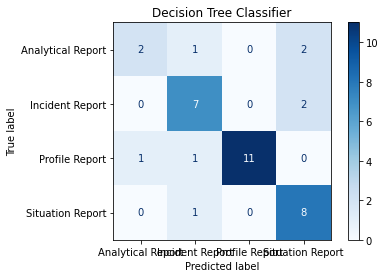

In [30]:
classifier = DecisionTreeClassifier(max_depth=200)
classifier.fit(x_train, y_train)

score_calulation(classifier, x_val, y_val, 'Decision Tree Classifier')

In [31]:
# Model with Random Forest Classifier
n_estimators = [50, 100, 150, 200]
max_depth = [5, 10, 25, 50, 100, 200]

for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        classifier = RandomForestClassifier(n_estimators=n_estimators[i], max_depth=max_depth[j])
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_train)
        f1_score_t = f1_score(y_train, y_pred, average='micro')
        print_out = 'Random Forest Classifier number of estimators ' +  str(n_estimators[i]) +  ' max depth ' + str(max_depth[j]) + ' F1 Score is ' + str(f1_score_t)
        print(print_out)

Random Forest Classifier number of estimators 50 max depth 5 F1 Score is 0.9717741935483871
Random Forest Classifier number of estimators 50 max depth 10 F1 Score is 0.9959677419354839
Random Forest Classifier number of estimators 50 max depth 25 F1 Score is 1.0
Random Forest Classifier number of estimators 50 max depth 50 F1 Score is 1.0
Random Forest Classifier number of estimators 50 max depth 100 F1 Score is 1.0
Random Forest Classifier number of estimators 50 max depth 200 F1 Score is 1.0
Random Forest Classifier number of estimators 100 max depth 5 F1 Score is 0.9919354838709677
Random Forest Classifier number of estimators 100 max depth 10 F1 Score is 0.9959677419354839
Random Forest Classifier number of estimators 100 max depth 25 F1 Score is 1.0
Random Forest Classifier number of estimators 100 max depth 50 F1 Score is 1.0
Random Forest Classifier number of estimators 100 max depth 100 F1 Score is 1.0
Random Forest Classifier number of estimators 100 max depth 200 F1 Score is 

Result Train dataset Random Forest Classifier
F1 Score is  1.0
Accuracy  Score is  1.0
Recall Score is  1.0
Train dataset Random Forest Classifier
[[60  0  0  0]
 [ 0 54  0  0]
 [ 0  0 63  0]
 [ 0  0  0 71]]
Result Validation dataset Random Forest Classifier
F1 Score is  0.8888888888888888
Accuracy  Score is  0.8888888888888888
Recall Score is  0.8888888888888888
Validation dataset Random Forest Classifier
[[ 5  0  0  0]
 [ 0  8  0  1]
 [ 0  1 12  0]
 [ 1  1  0  7]]


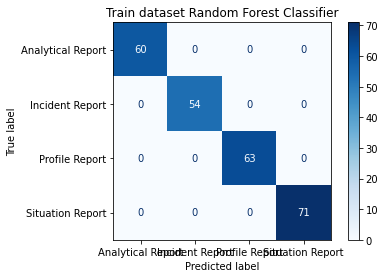

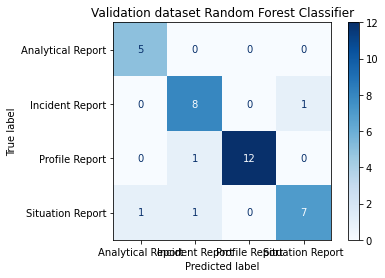

In [32]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=200)
classifier.fit(x_train, y_train)

score_calulation(classifier, x_train, y_train, 'Train dataset Random Forest Classifier')

score_calulation(classifier, x_val, y_val, 'Validation dataset Random Forest Classifier')

In [33]:
# Model with Ada Boost Classifier
n_estimators = [50, 100, 150, 200, 250, 500]


for i in range(len(n_estimators)):
    classifier = AdaBoostClassifier(n_estimators=n_estimators[i])
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_train)
    f1_score_t = f1_score(y_train, y_pred, average='micro')
    print_out = 'Ada Boost Classifier number of estimators ' +  str(n_estimators[i])  + ' F1 Score is ' + str(f1_score_t)
    print(print_out)

Ada Boost Classifier number of estimators 50 F1 Score is 0.6491935483870968
Ada Boost Classifier number of estimators 100 F1 Score is 0.5443548387096774
Ada Boost Classifier number of estimators 150 F1 Score is 0.6491935483870968
Ada Boost Classifier number of estimators 200 F1 Score is 0.5443548387096774
Ada Boost Classifier number of estimators 250 F1 Score is 0.6491935483870968
Ada Boost Classifier number of estimators 500 F1 Score is 0.5443548387096774


Result Train dataset Random Forest Classifier
F1 Score is  0.6491935483870968
Accuracy  Score is  0.6491935483870968
Recall Score is  0.6491935483870968
Train dataset Random Forest Classifier
[[58  2  0  0]
 [12 39  1  2]
 [16 26 21  0]
 [20  8  0 43]]
Result Validation dataset Random Forest Classifier
F1 Score is  0.5
Accuracy  Score is  0.5
Recall Score is  0.5
Validation dataset Random Forest Classifier
[[5 0 0 0]
 [0 6 0 3]
 [3 7 3 0]
 [3 2 0 4]]


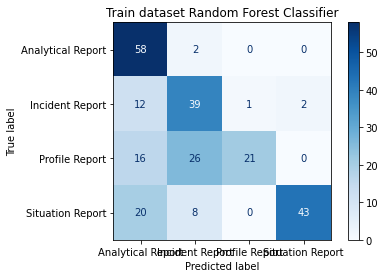

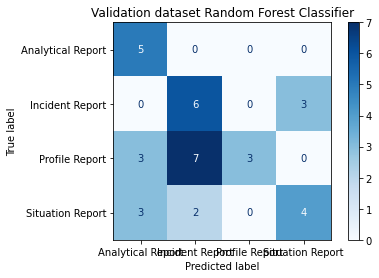

In [43]:
classifier = AdaBoostClassifier(n_estimators=250)
classifier.fit(x_train, y_train)

score_calulation(classifier, x_train, y_train, 'Train dataset Random Forest Classifier')

score_calulation(classifier, x_val, y_val, 'Validation dataset Random Forest Classifier')

In [35]:
# Model with SVC Classifier
c = [0.1, 1, 10, 100]
kernel_type = ["linear", "poly", "rbf", "sigmoid"]

for i in range(len(c)):
    for j in range(len(kernel_type)):
        classifier = SVC(C=c[i], kernel=kernel_type[j])
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_train)
        f1_score_t = f1_score(y_train, y_pred, average='micro')
        print_out = 'SVC Classifier Regularization parameter ' +  str(c[i]) +  ' Kernel type ' + str(kernel_type[j]) + ' F1 Score is ' + str(f1_score_t)
        print(print_out)

SVC Classifier Regularization parameter 0.1 Kernel type linear F1 Score is 0.8548387096774194
SVC Classifier Regularization parameter 0.1 Kernel type poly F1 Score is 0.3024193548387097
SVC Classifier Regularization parameter 0.1 Kernel type rbf F1 Score is 0.3387096774193548
SVC Classifier Regularization parameter 0.1 Kernel type sigmoid F1 Score is 0.2862903225806452
SVC Classifier Regularization parameter 1 Kernel type linear F1 Score is 0.967741935483871
SVC Classifier Regularization parameter 1 Kernel type poly F1 Score is 0.3185483870967742
SVC Classifier Regularization parameter 1 Kernel type rbf F1 Score is 0.5161290322580645
SVC Classifier Regularization parameter 1 Kernel type sigmoid F1 Score is 0.5080645161290323
SVC Classifier Regularization parameter 10 Kernel type linear F1 Score is 0.9717741935483871
SVC Classifier Regularization parameter 10 Kernel type poly F1 Score is 0.3387096774193548
SVC Classifier Regularization parameter 10 Kernel type rbf F1 Score is 0.54032258

Result Train dataset SVC Classifier
F1 Score is  0.967741935483871
Accuracy  Score is  0.967741935483871
Recall Score is  0.967741935483871
Train dataset SVC Classifier
[[59  0  1  0]
 [ 2 52  0  0]
 [ 1  0 62  0]
 [ 1  1  2 67]]
Result Validation dataset SVC Classifier
F1 Score is  0.8333333333333334
Accuracy  Score is  0.8333333333333334
Recall Score is  0.8333333333333334
Validation dataset SVC Classifier
[[ 3  0  2  0]
 [ 0  9  0  0]
 [ 1  0 11  1]
 [ 0  2  0  7]]


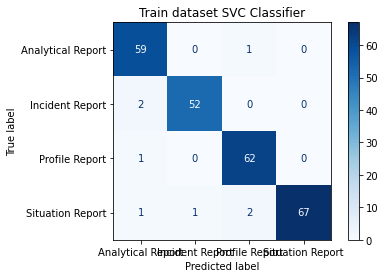

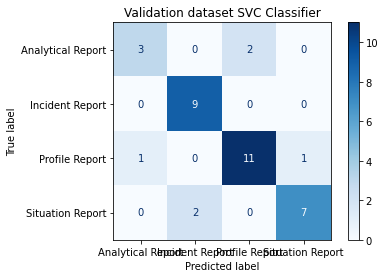

In [36]:
classifier = SVC(C=1, kernel="linear")
classifier.fit(x_train, y_train)

score_calulation(classifier, x_train, y_train, 'Train dataset SVC Classifier')

score_calulation(classifier, x_val, y_val, 'Validation dataset SVC Classifier')

Result Train dataset Gaussian Naive Bayes Classifier
F1 Score is  0.9314516129032258
Accuracy  Score is  0.9314516129032258
Recall Score is  0.9314516129032258
Train dataset Gaussian Naive Bayes Classifier
[[56  0  4  0]
 [ 2 50  0  2]
 [ 4  0 59  0]
 [ 3  1  1 66]]
Result Validation dataset Gaussian Naive Bayes Classifier
F1 Score is  0.8055555555555556
Accuracy  Score is  0.8055555555555556
Recall Score is  0.8055555555555556
Validation dataset Gaussian Naive Bayes Classifier
[[ 4  0  1  0]
 [ 1  5  0  3]
 [ 0  0 13  0]
 [ 1  1  0  7]]


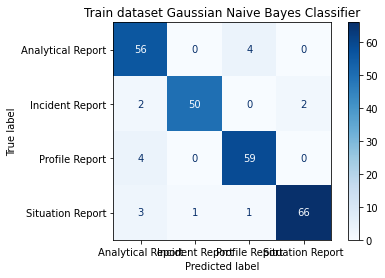

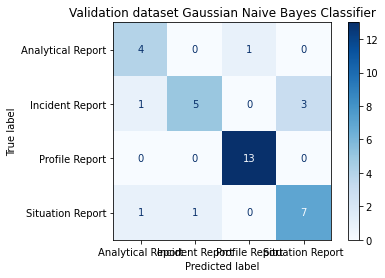

In [37]:
# Model with Gaussian Naive Bayes Classifier
classifier = GaussianNB()
classifier.fit(x_train, y_train)

score_calulation(classifier, x_train, y_train, 'Train dataset Gaussian Naive Bayes Classifier')

score_calulation(classifier, x_val, y_val, 'Validation dataset Gaussian Naive Bayes Classifier')

In [41]:
# Model with Multi-layer Perceptron Classifier
hidden_layer_sizes_val = [(2500, 250, ), (5000, 2500, 100, ), (4000, 2000, 500, 100, ) ] #, (4000, 3000, 2000, 1000, 500, 250, 100, )
max_iter_val = [300] #[50, 100, 200, 300, 400, 500]
learning_rate = [ 0.00001, 0.0001, 0.001]

for i in range(len(hidden_layer_sizes_val)):
    for j in range(len(max_iter_val)):
        for t in range(len(learning_rate)):
            classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes_val[i], learning_rate_init=learning_rate[t], max_iter=max_iter_val[j], activation = 'relu', solver='adam', alpha=0.00001,random_state=1, verbose=False)
            classifier.fit(x_train, y_train)
            y_pred = classifier.predict(x_train)
            f1_score_t = f1_score(y_train, y_pred, average='micro')
            print_out = 'Multi-layer Perceptron Classifier with hidden layers ' +  str(hidden_layer_sizes_val[i]) +  '  Learning rate ' + str(learning_rate[t]) + ' and max iterations ' + str(max_iter_val[j]) + ' F1 Score is ' + str(f1_score_t)
            print(print_out)

Multi-layer Perceptron Classifier with hidden layers (2500, 250)  Learning rate 1e-05 and max iterations 300 F1 Score is 0.7580645161290323
Multi-layer Perceptron Classifier with hidden layers (2500, 250)  Learning rate 0.0001 and max iterations 300 F1 Score is 0.5161290322580645
Multi-layer Perceptron Classifier with hidden layers (2500, 250)  Learning rate 0.001 and max iterations 300 F1 Score is 0.7379032258064516
Multi-layer Perceptron Classifier with hidden layers (5000, 2500, 100)  Learning rate 1e-05 and max iterations 300 F1 Score is 0.46774193548387094
Multi-layer Perceptron Classifier with hidden layers (5000, 2500, 100)  Learning rate 0.0001 and max iterations 300 F1 Score is 0.5120967741935484
Multi-layer Perceptron Classifier with hidden layers (5000, 2500, 100)  Learning rate 0.001 and max iterations 300 F1 Score is 0.907258064516129
Multi-layer Perceptron Classifier with hidden layers (4000, 2000, 500, 100)  Learning rate 1e-05 and max iterations 300 F1 Score is 0.5
Mult

Result Train dataset Multi-layer Perceptron Classifier
F1 Score is  0.8145161290322581
Accuracy  Score is  0.8145161290322581
Recall Score is  0.8145161290322581
Train dataset Multi-layer Perceptron Classifier
[[44  2 10  4]
 [ 3 46  4  1]
 [ 7  0 56  0]
 [ 7  2  6 56]]
Result Validation dataset Multi-layer Perceptron  Classifier
F1 Score is  0.8888888888888888
Accuracy  Score is  0.8888888888888888
Recall Score is  0.8888888888888888
Validation dataset Multi-layer Perceptron  Classifier
[[ 4  0  1  0]
 [ 0  8  1  0]
 [ 0  1 12  0]
 [ 0  0  1  8]]


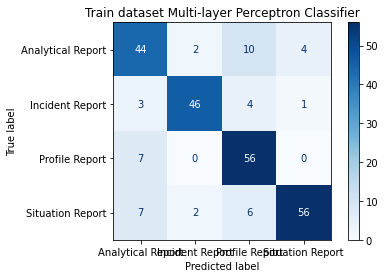

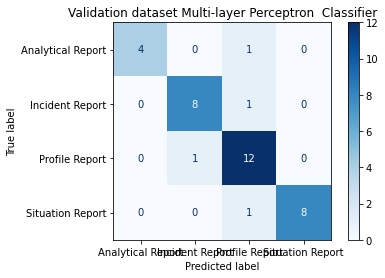

In [42]:
classifier = MLPClassifier(hidden_layer_sizes=(5000, 2500, 100,), learning_rate_init=0.001, max_iter=300, activation = 'relu', solver='adam', alpha=0.001,random_state=1, verbose=False)
classifier.fit(x_train, y_train)

score_calulation(classifier, x_train, y_train, 'Train dataset Multi-layer Perceptron Classifier')

score_calulation(classifier, x_val, y_val, 'Validation dataset Multi-layer Perceptron  Classifier')

In [ ]:
# Ensembles of the models
def ensemble_of_models(x_train, y_train, x_val, y_val):
    models= [DecisionTreeClassifier(max_depth=200), 
    RandomForestClassifier(n_estimators=100, max_depth=200),
    SVC(C=1, kernel="linear"),
    GaussianNB(),
    MLPClassifier(hidden_layer_sizes=(5000, 2500, 100,), learning_rate_init=0.001, max_iter=300, activation = 'relu', solver='adam', alpha=0.001, random_state=1, verbose=False)
     ]

    train_pred = np.zeros((y_train.shape[0], len(models)))
    val_pred = np.zeros((y_val.shape[0], len(models)))

    for i in range(len(models)):
        classifier = models[i]
        classifier.fit(x_train, y_train)
        train_pred[:, i] = classifier.predict(x_train)
        val_pred[:, i] = classifier.predict(x_val)
    
    train_en_pred = stats.mode(train_pred, axis=1)[0]
    f1_score_tr = f1_score(y_train, train_en_pred, average='micro')
    print('F1 Score for training set score for the enseble model is ', f1_score_tr)

    val_en_pred = stats.mode(val_pred, axis=1)[0]
    f1_score_va = f1_score(y_val, val_en_pred, average='micro')
    print('F1 Score for validation set score for the enseble model is ', f1_score_va)

    return


    

In [50]:
a = np.array([[6, 8, 3, 0],
              [3, 2, 1, 7],
              [8, 1, 8, 4],
              [5, 3, 0, 5],
              [4, 7, 5, 9]])
stats.mode(a, axis=1)[0]

array([[0],
       [1],
       [8],
       [5],
       [4]])

Pre trained BERT models

https://pypi.org/project/pytorch-pretrained-bert/

https://pytorch.org/hub/huggingface_pytorch-transformers/

https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1


Spacy linguistic features
https://spacy.io/usage/linguistic-features

TF-IDF https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

